In [1]:
#Installing necessary modules if necessary else just importing them

try:
    import chess
    import chess.svg
    from IPython.display import SVG, display
    import random
    import re
except:
    !pip install python-chess
    import chess
    import chess.svg

Chess squares are counted from 1 to 64. A1 is square 1, B1 is square 2 and so on. h8 is square 64.

### To move, we use the following function:
chess.Move(from_square: chess.Square, to_square: chess.Square, promotion: chess.PieceType | None = None, drop: chess.PieceType | None = None)

### Chess Piece Types
chess.PAWN: chess.PieceType= 1
chess.KNIGHT: chess.PieceType= 2
chess.BISHOP: chess.PieceType= 3
chess.ROOK: chess.PieceType= 4
chess.QUEEN: chess.PieceType= 5
chess.KING: chess.PieceType= 6

#### board.reset()
It sets the board in initial state

#### Less strict move push function
board.push_san("e4")
board.push_san("e5")


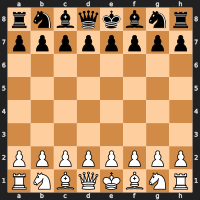

In [2]:
#Source: https://python-chess.readthedocs.io/en/latest/core.html#chess.BaseBoard
board = chess.Board()
chess.svg.board(board, size = 200) 

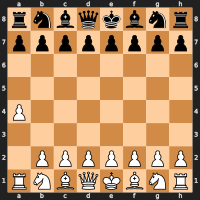

In [3]:
#This code shows to move a piece
board.reset()
move = chess.Move.from_uci("a2a4")  
board.push(move) 
chess.svg.board(board, size = 200) 

# The actual game

### Temporary Board
We are creating a temporary board by copying the current board. Then, we will add the current piec in the squares where it can move so it is easy for the user to identify places to move.
This line gives legal move for the square:

    square = chess.parse_square(user_input_square)
    piece_type = board.piece_type_at(square)
    legal_moves_filtered = [move for move in board.legal_moves if move.from_square == square]

In [4]:
#It will add cross in the places where the selected piece can move to.


def get_human_player_move(board):
    """
    Prompts the human player (White) to select a piece and its destination square, 
    providing visual feedback of legal moves. Handles input validation.

    Args:
        board (chess.Board): The current chess board state.

    Returns:
        chess.Move: The chosen move if valid, otherwise None.
    
    """
    char_1 = str.lower(input("Hello, you are team White, what piece do you want to move? Give it's position,eg: d5."))
    try:
        square = chess.parse_square(char_1)
        piece_type = board.piece_type_at(square)  

        if piece_type is None: 
            print("There's no piece on that square.")
        else:
            legal_moves_filtered = [
                move for move in board.legal_moves if move.from_square == square
            ]

            # Generate SVG of the board with highlighted squares
            svg_board = chess.svg.board(board=board, squares={move.to_square for move in legal_moves_filtered}, size=200)

            print("Possible Moves:", legal_moves_filtered)

            # Display the SVG
            display(SVG(svg_board))

            pos_1 = str.lower(input("What position you want to move it to? "))
            try:
                move = chess.Move.from_uci(char_1 + pos_1)
                if move in board.legal_moves:  
                    return move
                else:
                    print("Invalid move. Please try again.")
            except ValueError:
                print("Invalid input format. Please try again.")

    except ValueError:
        print("Invalid square format.")


def get_ai_player_move(board, difficulty):
    """
    Determines the AI's move based on the selected difficulty level, using 
    appropriate search algorithms.

    Args:
        board (chess.Board): The current chess board state.
        difficulty (str): The desired difficulty level ("easy", "medium", "challenging", "pro").

    Returns:
        chess.Move: The chosen AI move, otherwise None if there's an error. 
    
    """
    if str.lower(difficulty) == "easy":  # This will remove any capitalization errors from the user input
        move = get_random_player_move(board)
        # If the move is None, return None or raise an exception
        if move is None:
            return None
    elif str.lower(difficulty) == "medium":
        move = minimax_move(board, 2)  # Using minimax with depth 2 for medium difficulty
    elif str.lower(difficulty) == "challenging":
        move = minimax_move(board, 4)  # Using minimax with depth 4 for challenging difficulty
    elif str.lower(difficulty) == "pro":
        move=minimax_move_pro(board,4) #Uses the updated heuristics at depth 4
    else:
        print("Invalid difficulty level. Please choose between 'easy', 'medium', or 'challenging'.")
        move = None
    return move


def get_random_player_move(board):
    
    """
    Selects a random legal move for the AI. 

    Args:
        board (chess.Board): The current chess board state.

    Returns:
        chess.Move: A randomly chosen legal move.
        None: If no legal moves are available.
    """
    legal_moves = list(board.legal_moves)  # Get all legal moves

    # If there are no legal moves, return None
    if not legal_moves:
        return None

    random_move = random.choice(legal_moves)
    return random_move


The code does consider different weights for different chess pieces. The weights are assigned in the `evaluate_board` function:

```python
material = 100*(wp-bp)+320*(wn-bn)+330*(wb-bb)+500*(wr-br)+900*(wq-bq)
```

Here, `wp`, `wn`, `wb`, `wr`, and `wq` are the counts of white pawns, knights, bishops, rooks, and queens, respectively. `bp`, `bn`, `bb`, `br`, and `bq` are the counts of black pawns, knights, bishops, rooks, and queens, respectively.

The weights assigned to the pieces are as follows:

- Pawn: 100
- Knight: 320
- Bishop: 330
- Rook: 500
- Queen: 900
- King:

Piece tables source: https://www.chessprogramming.org/Simplified_Evaluation_Function

**Why the Queen Table Might Be Similar**

* **Flexibility:**  The queen is the most powerful piece, combining the mobility of rook and bishop. This gives it inherent value across the board in both the opening and endgame.
* **Central Control:**  In both phases, central control is important for the queen.  A centralized queen commands the maximum number of squares.
* **Open Lines:** The queen thrives on open files and diagonals - valuable in both opening and endgame scenarios. 

**Potential Subtle Endgame Changes:**

While the core principles remain similar, a few subtle adjustments might be considered for an endgame queen table:

* **Open Files:**  In the endgame, where fewer pieces remain, a queen on a completely open file can gain additional influence. You could slightly increase the values for central open file squares.
* **King Hunt:** If the opponent's king is exposed, the ability to control squares around the enemy king becomes more impactful. Consider giving slightly higher values to squares that attack the typical king's position in the endgame.

**General Differences Between Opening and Endgame Tables**

1. **Pawn Structures Matter More:** In the endgame, pawn structures (passed pawns, isolated pawns, pawn chains) heavily influence the game. Endgame tables often reflect strong synergies of other pieces with these formations. 

2. **Piece Activity:** Openings are about development and seizing central control. Thus, opening tables tend to reward squares that lead to active placement. Endgame tables might be less focused on 'ideal starting' squares, and more on positions with maximum influence and potential.

3. **King Safety:** In the opening, the king is fragile.  Opening tables often heavily discourage exposing the king to the center. Endgame tables can place slightly more emphasis on king activity as it has fewer immediate threats.

In [5]:
# This function is for the medium and challenging ai mode
def evaluate_board(board):
    """
    Evaluates the current chess board state, favoring checkmates, checks, and material advantage.

    Args:
        board (chess.Board): The current chess board state.

    Returns:
        int: A numerical evaluation of the board. Positive values favor White, negative values favor Black.
    """
    if board.is_checkmate():
        if board.turn:
            return -99999
        else:
            return 99999
    if board.is_stalemate():
        return 0
    if board.is_insufficient_material():
        return 0
    
    #This is a risk-neutral player, would get as much happiness by winning than by losing
    if board.is_check():
        if board.turn:
            return -9999
        else:
            return 9999

    wp = len(board.pieces(chess.PAWN, chess.WHITE))
    bp = len(board.pieces(chess.PAWN, chess.BLACK))
    wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
    bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
    wb = len(board.pieces(chess.BISHOP, chess.WHITE))
    bb = len(board.pieces(chess.BISHOP, chess.BLACK))
    wr = len(board.pieces(chess.ROOK, chess.WHITE))
    br = len(board.pieces(chess.ROOK, chess.BLACK))
    wq = len(board.pieces(chess.QUEEN, chess.WHITE))
    bq = len(board.pieces(chess.QUEEN, chess.BLACK))

  


        # ------ Evaluation Tables --------

    # Pawn
    pawn_table_start = [
        0,  0,  0,  0,  0,  0,  0,  0,
        50, 50, 50, 50, 50, 50, 50, 50,
        10, 10, 20, 30, 30, 20, 10, 10,
        5,  5, 10, 25, 25, 10,  5,  5,
        0,  0,  0, 20, 20,  0,  0,  0,
        5, -5,-10,  0,  0,-10, -5,  5,
        5, 10, 10,-20,-20, 10, 10,  5,
        0,  0,  0,  0,  0,  0,  0,  0]

    pawn_table_end = [
        0,  0,  0,  0,  0,  0,  0,  0,
        50, 50, 50, 50, 50, 50, 50, 50,
        30, 30, 30, 30, 30, 30, 30, 30,
        10, 10, 20, 30, 30, 20, 10, 10,
        5,  5, 10, 25, 25, 10,  5,  5,
        0,  0,  0, 20, 20,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0]

    # Knight
    knight_table_start = [
        -50,-40,-30,-30,-30,-30,-40,-50,
        -40,-20,  0,  0,  0,  0,-20,-40,
        -30,  0, 10, 15, 15, 10,  0,-30,
        -30,  5, 15, 20, 20, 15,  5,-30,
        -30,  0, 15, 20, 20, 15,  0,-30,
        -30,  5, 10, 15, 15, 10,  5,-30,
        -40,-20,  0,  5,  5,  0,-20,-40,
        -50,-40,-30,-30,-30,-30,-40,-50,]

    knight_table_end = [
        -50,-40,-30,-30,-30,-30,-40,-50,
        -40,-20,  0,  0,  0,  0,-20,-40,
        -30,  0, 10, 15, 15, 10,  0,-30,
        -30,  5, 15, 20, 20, 15,  5,-30,
        -30,  0, 15, 20, 20, 15,  0,-30,
        -30,  5, 10, 15, 15, 10,  5,-30,
        -40,-20,  0,  5,  5,  0,-20,-40,
        -50,-40,-30,-30,-30,-30,-40,-50,]

    # Bishop
    bishop_table_start = [
        -20,-10,-10,-10,-10,-10,-10,-20,
        -10,  0,  0,  0,  0,  0,  0,-10,
        -10,  0,  5, 10, 10,  5,  0,-10,
        -10,  5,  5, 10, 10,  5,  5,-10,
        -10,  0, 10, 10, 10, 10,  0,-10,
        -10, 10, 10, 10, 10, 10, 10,-10,
        -10,  5,  0,  0,  0,  0,  5,-10,
        -20,-10,-10,-10,-10,-10,-10,-20,]

    bishop_table_end = [
        -20,-10,-10,-10,-10,-10,-10,-20,
        -10,  0,  0,  0,  0,  0,  0,-10,
        -10,  0,  5, 10, 10,  5,  0,-10,
        -10,  5,  5, 10, 10,  5,  5,-10,
        -10,  0, 10, 10, 10, 10,  0,-10,
        -10, 10, 10, 10, 10, 10, 10,-10,
        -10,  5,  0,  0,  0,  0,  5,-10,
        -20,-10,-10,-10,-10,-10,-10,-20,]

    # Rook
    rook_table_start = [
        0,  0,  0,  0,  0,  0,  0,  0,
        5, 10, 10, 10, 10, 10, 10,  5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
        0,  0,  0,  5,  5,  0,  0,  0]

    rook_table_end = [
        0,  0,  0,  5,  5,  0,  0,  0,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
        5, 10, 10, 10, 10, 10, 10,  5,
        0,  0,  0,  0,  0,  0,  0,  0]


    # Queen
    queen_table_start = [
        -20,-10,-10, -5, -5,-10,-10,-20,
        -10,  0,  0,  0,  0,  0,  0,-10,
        -10,  0,  5,  5,  5,  5,  0,-10,
         -5,  0,  5,  5,  5,  5,  0, -5,
          0,  0,  5,  5,  5,  5,  0, -5,
        -10,  5,  5,  5,  5,  5,  0,-10,
        -10,  0,  5,  0,  0,  0,  0,-10,
        -20,-10,-10, -5, -5,-10,-10,-20]

    queen_table_end = queen_table_start  # Queen's table remains the same in the endgame

    # King
    king_table_start = [
         20, 30, 10,  0,  0, 10, 30, 20,
         20, 20,  0,  0,  0,  0, 20, 20,
        -10,-20,-20,-20,-20,-20,-20,-10,
        -20,-30,-30,-40,-40,-30,-30,-20,
        -30,-40,-40,-50,-50,-40,-40,-30,
        -30,-40,-40,-50,-50,-40,-40,-30,
        -30,-40,-40,-50,-50,-40,-40,-30,
        -30,-40,-40,-50,-50,-40,-40,-30]

    king_table_end = [
        -50,-40,-30,-20,-20,-30,-40,-50,
        -30,-20,-10,  0,  0,-10,-20,-30,
        -30,-10, 20, 30, 30, 20,-10,-30,
        -30,-10, 30, 40, 40, 30,-10,-30,
        -30,-10, 30, 40, 40, 30,-10,-30,
        -30,-10, 20, 30, 30, 20,-10,-30,
        -30,-30,  0,  0,  0,  0,-30,-30,
        -50,-30,-30,-30,-30,-30,-30,-50]


    # Count the total number of pieces on the board
    total_pieces = wp+bp+wn+bn+wb+bb+wr+br+wq+bq

    # If the total number of pieces is less than 10, we will use end game table
    if total_pieces <= 10:
        kingstable, queenstable, rookstable, bishopstable, knightstable,pawntable = king_table_end, queen_table_end, rook_table_end, bishop_table_end, knight_table_end,pawn_table_end

    else:
        kingstable, queenstable, rookstable, bishopstable, knightstable,pawntable = king_table_start, queen_table_start, rook_table_start, bishop_table_start, knight_table_start,pawn_table_start
        
               
        
    
    material = 100*(wp-bp)+320*(wn-bn)+330*(wb-bb)+500*(wr-br)+900*(wq-bq)

    pawnsq = sum([pawntable[i] for i in board.pieces(chess.PAWN, chess.WHITE)])
    pawnsq= pawnsq + sum([-pawntable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.PAWN, chess.BLACK)])
    knightsq = sum([knightstable[i] for i in board.pieces(chess.KNIGHT, chess.WHITE)])
    knightsq = knightsq + sum([-knightstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KNIGHT, chess.BLACK)])
    bishopsq= sum([bishopstable[i] for i in board.pieces(chess.BISHOP, chess.WHITE)])
    bishopsq= bishopsq + sum([-bishopstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.BISHOP, chess.BLACK)])
    rooksq = sum([rookstable[i] for i in board.pieces(chess.ROOK, chess.WHITE)]) 
    rooksq = rooksq + sum([-rookstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.ROOK, chess.BLACK)])
    queensq = sum([queenstable[i] for i in board.pieces(chess.QUEEN, chess.WHITE)]) 
    queensq = queensq + sum([-queenstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.QUEEN, chess.BLACK)])
    kingsq = sum([kingstable[i] for i in board.pieces(chess.KING, chess.WHITE)]) 
    kingsq = kingsq + sum([-kingstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KING, chess.BLACK)])

    eval = material + pawnsq + knightsq + bishopsq+ rooksq+ queensq + kingsq
    if board.turn:
        return eval
    else:
        return -eval

def minimax(board, depth, alpha, beta, maximizing_player):
    """
    Implementation of the Minimax algorithm for finding the optimal move in a chess game. 

    Args:
        board (chess.Board): The current chess board state.
        depth (int): The search depth for the minimax algorithm.
        alpha (int): The current alpha value for alpha-beta pruning.
        beta (int): The current beta value for alpha-beta pruning.
        maximizing_player (bool): True if it's the maximizing player's turn, False otherwise.

    Returns: 
        int: The evaluation of the best possible move from the current position.
    """
    if depth == 0 or board.is_game_over():
        return evaluate_board(board)

    if maximizing_player:
        max_eval = -9999999 #We would typically add - infinity here
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = 9999999 #We would typically add infinity here
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

def minimax_move(board, depth): #Move for AI using minimax
    """
    Finds the best move for the AI using the Minimax algorithm with a specified depth.

    Args:
        board (chess.Board): The current chess board state.
        depth (int): The search depth for minimax.

    Returns:
        chess.Move: The best move found by the algorithm.
        None: If no legal moves are available or if the evaluation fails.
     """
    max_eval = -9999
    best_move = None
    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, -9999, 9999, False)
        board.pop()
        if eval > max_eval:
            max_eval = eval
            best_move = move
    #If it cannot evaluate best move, it will give a random move. 
    if best_move == None:
        #It will check if there's any legal moves left else it is game over
        if len(list(board.legal_moves)) == 0:
            return None #It will return None
        best_move = random.choice(list(board.legal_moves))
    return best_move

The player who wins is the one opposite of the player who is in checkmate. To determine this, we can use the board.turn property within the checkmate condition:

### How to run the game?
The `play_game()` function has the following parameters.
- board: This is the parameter for chessboard and is already initialized with the same name
`board = chess.Board()
chess.svg.board(board, size = 200) `
You can just enter `board` as the first parameter.
- player1_type: This is the white player. Do you want it to be a Human or an AI? It is set to human by default.
- player2_type:This is the black player. Do you want it to be a Human or AI? It is set to human by default.
- difficuly_1: Use if player 1 is an AI. The available difficulty levels are easy, medium and challenging.
- difficuly_2: Use if player 2 is an AI. The available difficulty levels are easy, medium and challenging.
- total_moves: No need to use this parameter. 

# Game Loop

In [6]:

board.reset()
def play_game(board, player1_type="human", player2_type="human", difficulty_1="easy", difficulty_2="medium", total_moves = 0):
    """
    Manages a complete chess game between two players (human or AI). 

    Args:
        board (chess.Board): The starting chess board configuration.
        player1_type (str, optional): Type of player 1. Can be "human" or "ai". Defaults to "human".
        player2_type (str, optional): Type of player 2. Can be "human" or "ai". Defaults to "human".
        difficulty_1 (str, optional): Difficulty for AI player 1. Options are "easy", "medium", "challenging", "pro". Defaults to "easy".
        difficulty_2 (str, optional): Difficulty for AI player 2. Options are "easy", "medium", "challenging", "pro". Defaults to "medium".
        total_moves (int, optional): The initial total moves taken. Defaults to 0.
    """
    game_over = False

    while not game_over:
        if player1_type == "human":
            move = get_human_player_move(board)
        else:
            move = get_ai_player_move(board, difficulty_1)
            if move == None:
                if board.is_checkmate():
                    game_over = True
                    if board.turn: 
                        print("Checkmate! Black Wins!")
                        print("total moves per player: ", total_moves)
                    else: 
                        print("Checkmate! White Wins!")
                        print("total moves per player: ", total_moves)
                elif board.is_stalemate():
                    game_over = True
                    print("Draw due to stalemate!")
                    print("total moves per player: ", total_moves)
                elif board.is_insufficient_material():
                    game_over = True
                    print("Draw due to insufficient material!")
                    print("total moves per player: ", total_moves)
                elif board.is_seventyfive_moves():
                    game_over = True
                    print("Draw due to 75-move rule!")
                    print("total moves per player: ", total_moves)
                elif board.is_fivefold_repetition():
                    game_over = True
                    print("Draw due to fivefold repetition!")
                    print("total moves per player: ", total_moves)
                elif board.is_variant_draw():
                    game_over = True
                    print("Draw due to variant-specific rules!")
                    print("total moves per player: ", total_moves)
                return #Using return here so the None move doesn't get pushed
        board.push(move)

        if player2_type == "human":
            move = get_human_player_move(board)
        else:
            move = get_ai_player_move(board, difficulty_2)
            if move == None:
                if board.is_checkmate():
                    game_over = True
                    if board.turn: 
                        print("Checkmate! Black Wins!")
                        print("total moves per player: ", total_moves)
                    else: 
                        print("Checkmate! White Wins!")
                        print("total moves per player: ", total_moves)
                elif board.is_stalemate():
                    game_over = True
                    print("Draw due to stalemate!")
                    print("total moves per player: ", total_moves)
                elif board.is_insufficient_material():
                    game_over = True
                    print("Draw due to insufficient material!")
                    print("total moves per player: ", total_moves)
                elif board.is_seventyfive_moves():
                    game_over = True
                    print("Draw due to 75-move rule!")
                    print("total moves per player: ", total_moves)
                elif board.is_fivefold_repetition():
                    game_over = True
                    print("Draw due to fivefold repetition!")
                    print("total moves per player: ", total_moves)
                elif board.is_variant_draw():
                    game_over = True
                    print("Draw due to variant-specific rules!")
                    print("total moves per player: ", total_moves)
                return #Using return here so the None move doesn't get pushed
        board.push(move)
        total_moves+=1
        

        display(chess.svg.board(board, size=200))

        if board.is_checkmate():
            game_over = True
            if board.turn: 
                print("Checkmate! Black Wins!")
                print("total moves per player: ", total_moves)
            else: 
                print("Checkmate! White Wins!")
                print("total moves per player: ", total_moves)
        elif board.is_stalemate():
            game_over = True
            print("Draw due to stalemate!")
            print("total moves per player: ", total_moves)
        elif board.is_insufficient_material():
            game_over = True
            print("Draw due to insufficient material!")
            print("total moves per player: ", total_moves)
        elif board.is_seventyfive_moves():
            game_over = True
            print("Draw due to 75-move rule!")
            print("total moves per player: ", total_moves)
        elif board.is_fivefold_repetition():
            game_over = True
            print("Draw due to fivefold repetition!")
            print("total moves per player: ", total_moves)
        elif board.is_variant_draw():
            game_over = True
            print("Draw due to variant-specific rules!")
            print("total moves per player: ", total_moves)


## Some game results
- Challenging player against easy player
    - Won the game in 21 moves.
- Challenging player against medium player
    - Won the game in 60 moves.
- Challenging player against a human
    - Won the game in __ moves?
- Medium player against easy player
    - Draw due to fivefold repetition. However easy player only had the king left.
- Medium player against human player
    - Lost the game in _ moves.
- Easy player against human player
    - Lost the game in _ moves
- Easy player against easy player
    - Draw in 126 moves


<h2 style="text-align: center;">Chess UI</h2>

Welcome to Chess AI! Here you can play with a friend, AI or battle two AI's and have fun :))))))
Do you want to play as the White player or let the AI play (type 'human' or 'ai') ?ai
Exciting! How tough do you want the AI to be?(easy, medium, challenging)medium
Do you want to play as the Black player or let the AI play (type 'human' or 'ai') ?ai
Exciting! How tough do you want the AI to be?(easy, medium, challenging)easy


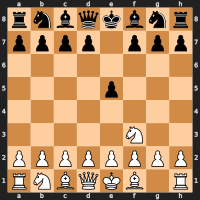

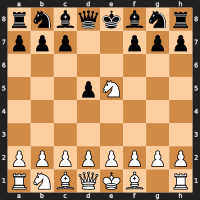

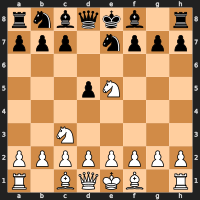

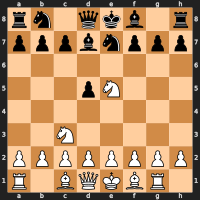

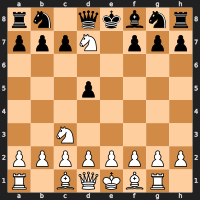

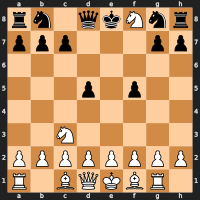

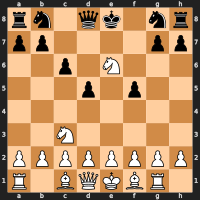

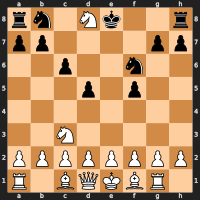

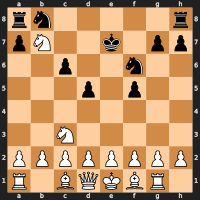

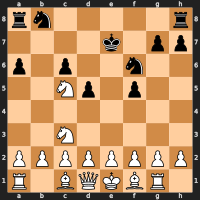

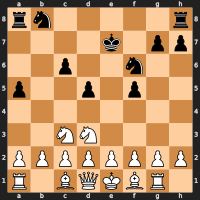

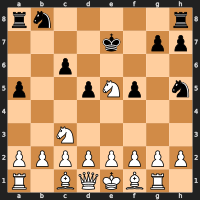

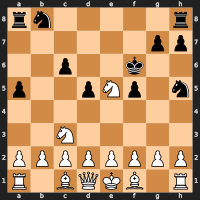

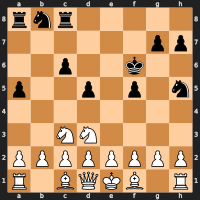

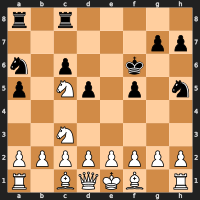

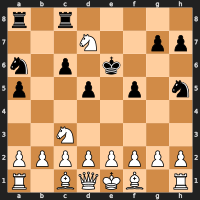

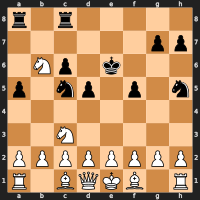

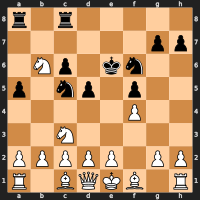

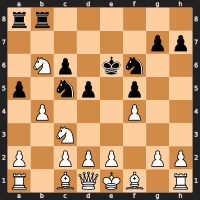

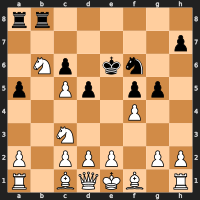

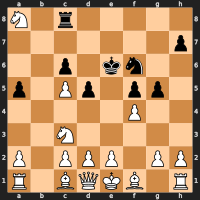

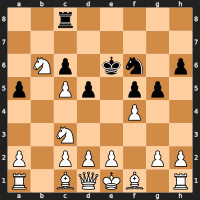

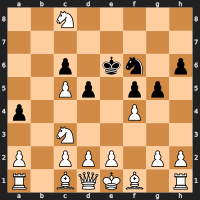

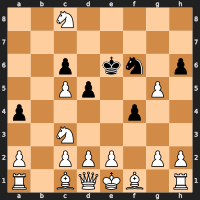

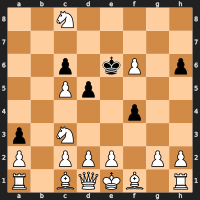

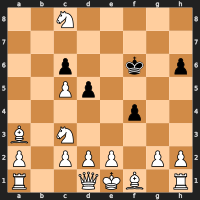

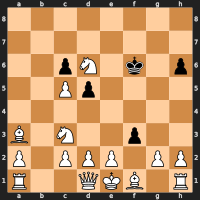

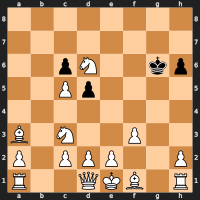

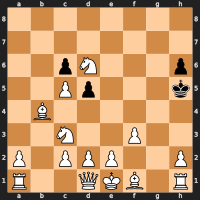

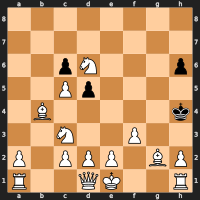

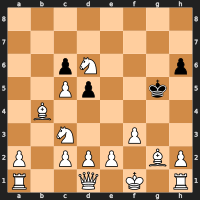

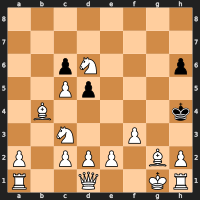

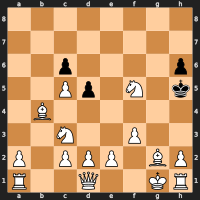

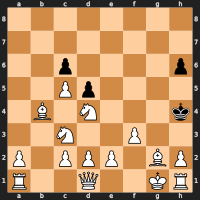

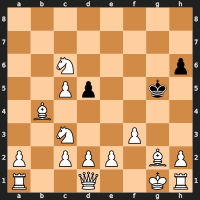

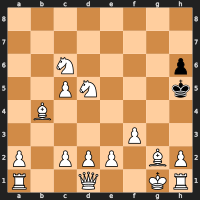

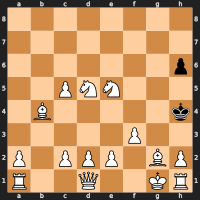

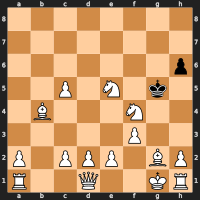

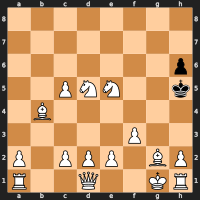

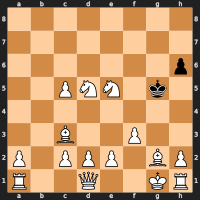

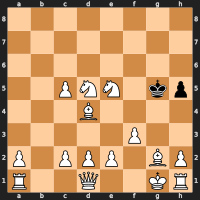

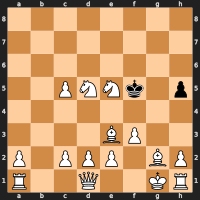

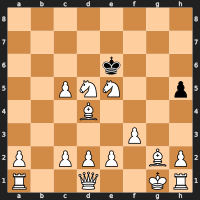

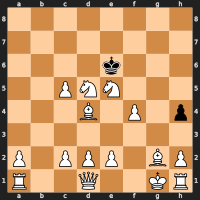

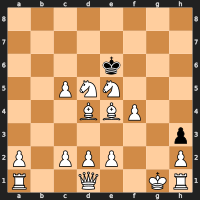

Checkmate! White Wins!
total moves per player:  45


In [8]:
#This does not have the option to run pro, but you can still type it.
board.reset()
print("Welcome to Chess AI! Here you can play with a friend, AI or battle two AI's and have fun :))))))")
player1_type = input("Do you want to play as the White player or let the AI play (type 'human' or 'ai') ?")
if player1_type == "ai":
    difficulty_1 = input("Exciting! How tough do you want the AI to be?(easy, medium, challenging)")
player2_type = input("Do you want to play as the Black player or let the AI play (type 'human' or 'ai') ?")
if player2_type == "ai":
    difficulty_2 = input("Exciting! How tough do you want the AI to be?(easy, medium, challenging)")

play_game(board, player1_type, player2_type, difficulty_1, difficulty_2)

Note that this heuristic especially with lower depth like `depth = 2` struggles to checkmate the king at the end.
So, we need a better heuristic that focuses on that. We will still use the current evaluation function and will just add scores for King's proximity there.

In [9]:
def calculate_king_safety(board, players_turn):
    """
    Evaluates the safety of the king for the specified player.

    Args:
        board (chess.Board): The current chess board state.
        players_turn (bool): True if it's the player's turn, False otherwise.

    Returns:
        int: A score representing king safety. Higher scores indicate greater safety.
    """

    king_square = board.king(players_turn) 
    opponent_turn = not players_turn

    # Factors influencing king safety
    attacking_pieces_score = sum(len(board.attackers(opponent_turn, square)) for square in chess.SQUARES)  
    escape_squares_score = len(board.attacks(king_square)) 
    defending_pieces_score = sum(len(board.attackers(players_turn, square)) for square in chess.SQUARES)

    # Weight these factors (adjust depending on how aggressive you want your AI to be)
    king_safety_score = -20 * attacking_pieces_score + 10 * escape_squares_score + 5 * defending_pieces_score 

    return king_safety_score

"""
A passed pawn is a pawn that has no opposing pawns in front of it on the same file, nor any opposing pawns 
that could capture it on an adjacent file if it advances.
"""


def is_passed_pawn(board, pawn):
    """
    Determines if a given pawn is a passed pawn.

    Args:
        board (chess.Board): The current board state.
        pawn (chess.Square): The square of the pawn to check.

    Returns:
        bool: True if the pawn is a passed pawn, False otherwise.
    """

    file = chess.square_file(pawn)
    rank = chess.square_rank(pawn)

    # Check for blocking pawns on the same file
    for r in range(rank + 1, 8):  # Ranks in front of the pawn
        if board.piece_at(chess.square(file, r)): 
            return False

    # Check for potential captures on adjacent files
    for adjacent_file in [file - 1, file + 1]:
        if adjacent_file in range(8):
            if board.piece_type_at(chess.square(adjacent_file, rank + 1)) == chess.PAWN:
                return False

    return True  # If we haven't found any blocking or attacking pawns, it's passed





def calculate_passed_pawn_threat(board):
    """
    Calculates the threat level posed by passed pawns of the current player. I am using a higher weight for 
    distance to opponent king then promotion as the goal is to checkmate as soon as possible.

    Args:
        board (chess.Board): The current chess board state.

    Returns:
        int: A score representing passed pawn threat. Higher scores indicate a bigger threat.
    """

    passed_pawn_score = 0
    opponent_king_square = board.king(not board.turn)#Gets the non_current turn and finds the position of the king

    for pawn in board.pieces(chess.PAWN, board.turn):
        if is_passed_pawn(board, pawn):
            continue  # Only consider passed pawns

        # Factors for passed pawn threat
        distance_to_promotion = 7 - chess.square_rank(pawn)
        distance_to_opponent_king = chess.square_distance(pawn, opponent_king_square) 

        # Weight factors to create a score (higher values mean bigger threat)
        passed_pawn_score += 50 * (1 / distance_to_promotion) + 60 * (1 / distance_to_opponent_king)

    return passed_pawn_score 


In [10]:
#I will use a pro player for the new heuristics
def evaluate_board_pro(board):
    """
    Evaluates the current chess board state, prioritizing checkmates, checks, material advantage, 
    positional strength (using piece-square tables), king safety, and passed pawn threats.

    Args:
        board (chess.Board): The current chess board state.

    Returns:
        int: A numerical evaluation of the board. Positive values favor White, negative values favor Black.
    """
    if board.is_checkmate():
        if board.turn:
            return -99999
        else:
            return 99999
    if board.is_stalemate():
        return 0
    if board.is_insufficient_material():
        return 0
    
    #This is a risk-neutral player, would get as much happiness by winning than by losing
    if board.is_check():
        if board.turn:
            return -9999
        else:
            return 9999


    wp = len(board.pieces(chess.PAWN, chess.WHITE))
    bp = len(board.pieces(chess.PAWN, chess.BLACK))
    wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
    bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
    wb = len(board.pieces(chess.BISHOP, chess.WHITE))
    bb = len(board.pieces(chess.BISHOP, chess.BLACK))
    wr = len(board.pieces(chess.ROOK, chess.WHITE))
    br = len(board.pieces(chess.ROOK, chess.BLACK))
    wq = len(board.pieces(chess.QUEEN, chess.WHITE))
    bq = len(board.pieces(chess.QUEEN, chess.BLACK))

  


        # ------ Evaluation Tables --------

    # Pawn
    pawn_table_start = [
        0,  0,  0,  0,  0,  0,  0,  0,
        50, 50, 50, 50, 50, 50, 50, 50,
        10, 10, 20, 30, 30, 20, 10, 10,
        5,  5, 10, 25, 25, 10,  5,  5,
        0,  0,  0, 20, 20,  0,  0,  0,
        5, -5,-10,  0,  0,-10, -5,  5,
        5, 10, 10,-20,-20, 10, 10,  5,
        0,  0,  0,  0,  0,  0,  0,  0]

    pawn_table_end = [
        0,  0,  0,  0,  0,  0,  0,  0,
        50, 50, 50, 50, 50, 50, 50, 50,
        30, 30, 30, 30, 30, 30, 30, 30,
        10, 10, 20, 30, 30, 20, 10, 10,
        5,  5, 10, 25, 25, 10,  5,  5,
        0,  0,  0, 20, 20,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0]

    # Knight
    knight_table_start = [
        -50,-40,-30,-30,-30,-30,-40,-50,
        -40,-20,  0,  0,  0,  0,-20,-40,
        -30,  0, 10, 15, 15, 10,  0,-30,
        -30,  5, 15, 20, 20, 15,  5,-30,
        -30,  0, 15, 20, 20, 15,  0,-30,
        -30,  5, 10, 15, 15, 10,  5,-30,
        -40,-20,  0,  5,  5,  0,-20,-40,
        -50,-40,-30,-30,-30,-30,-40,-50,]

    knight_table_end = [
        -50,-40,-30,-30,-30,-30,-40,-50,
        -40,-20,  0,  0,  0,  0,-20,-40,
        -30,  0, 10, 15, 15, 10,  0,-30,
        -30,  5, 15, 20, 20, 15,  5,-30,
        -30,  0, 15, 20, 20, 15,  0,-30,
        -30,  5, 10, 15, 15, 10,  5,-30,
        -40,-20,  0,  5,  5,  0,-20,-40,
        -50,-40,-30,-30,-30,-30,-40,-50,]

    # Bishop
    bishop_table_start = [
        -20,-10,-10,-10,-10,-10,-10,-20,
        -10,  0,  0,  0,  0,  0,  0,-10,
        -10,  0,  5, 10, 10,  5,  0,-10,
        -10,  5,  5, 10, 10,  5,  5,-10,
        -10,  0, 10, 10, 10, 10,  0,-10,
        -10, 10, 10, 10, 10, 10, 10,-10,
        -10,  5,  0,  0,  0,  0,  5,-10,
        -20,-10,-10,-10,-10,-10,-10,-20,]

    bishop_table_end = [
        -20,-10,-10,-10,-10,-10,-10,-20,
        -10,  0,  0,  0,  0,  0,  0,-10,
        -10,  0,  5, 10, 10,  5,  0,-10,
        -10,  5,  5, 10, 10,  5,  5,-10,
        -10,  0, 10, 10, 10, 10,  0,-10,
        -10, 10, 10, 10, 10, 10, 10,-10,
        -10,  5,  0,  0,  0,  0,  5,-10,
        -20,-10,-10,-10,-10,-10,-10,-20,]

    # Rook
    rook_table_start = [
        0,  0,  0,  0,  0,  0,  0,  0,
        5, 10, 10, 10, 10, 10, 10,  5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
        0,  0,  0,  5,  5,  0,  0,  0]

    rook_table_end = [
        0,  0,  0,  5,  5,  0,  0,  0,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
       -5,  0,  0,  0,  0,  0,  0, -5,
        5, 10, 10, 10, 10, 10, 10,  5,
        0,  0,  0,  0,  0,  0,  0,  0]


    # Queen
    queen_table_start = [
        -20,-10,-10, -5, -5,-10,-10,-20,
        -10,  0,  0,  0,  0,  0,  0,-10,
        -10,  0,  5,  5,  5,  5,  0,-10,
         -5,  0,  5,  5,  5,  5,  0, -5,
          0,  0,  5,  5,  5,  5,  0, -5,
        -10,  5,  5,  5,  5,  5,  0,-10,
        -10,  0,  5,  0,  0,  0,  0,-10,
        -20,-10,-10, -5, -5,-10,-10,-20]

    queen_table_end = queen_table_start  # Queen's table remains the same in the endgame

    # King
    king_table_start = [
         20, 30, 10,  0,  0, 10, 30, 20,
         20, 20,  0,  0,  0,  0, 20, 20,
        -10,-20,-20,-20,-20,-20,-20,-10,
        -20,-30,-30,-40,-40,-30,-30,-20,
        -30,-40,-40,-50,-50,-40,-40,-30,
        -30,-40,-40,-50,-50,-40,-40,-30,
        -30,-40,-40,-50,-50,-40,-40,-30,
        -30,-40,-40,-50,-50,-40,-40,-30]

    king_table_end = [
        -50,-40,-30,-20,-20,-30,-40,-50,
        -30,-20,-10,  0,  0,-10,-20,-30,
        -30,-10, 20, 30, 30, 20,-10,-30,
        -30,-10, 30, 40, 40, 30,-10,-30,
        -30,-10, 30, 40, 40, 30,-10,-30,
        -30,-10, 20, 30, 30, 20,-10,-30,
        -30,-30,  0,  0,  0,  0,-30,-30,
        -50,-30,-30,-30,-30,-30,-30,-50]


    # Count the total number of pieces on the board
    total_pieces = wp+bp+wn+bn+wb+bb+wr+br+wq+bq

    # If the total number of pieces is less than 10, we will use end game table
    if total_pieces <= 10:
        kingstable, queenstable, rookstable, bishopstable, knightstable,pawntable = king_table_end, queen_table_end, rook_table_end, bishop_table_end, knight_table_end,pawn_table_end

    else:
        kingstable, queenstable, rookstable, bishopstable, knightstable,pawntable = king_table_start, queen_table_start, rook_table_start, bishop_table_start, knight_table_start,pawn_table_start
        
               
        
    
    material = 100*(wp-bp)+320*(wn-bn)+330*(wb-bb)+500*(wr-br)+900*(wq-bq)

    pawnsq = sum([pawntable[i] for i in board.pieces(chess.PAWN, chess.WHITE)])
    pawnsq= pawnsq + sum([-pawntable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.PAWN, chess.BLACK)])
    knightsq = sum([knightstable[i] for i in board.pieces(chess.KNIGHT, chess.WHITE)])
    knightsq = knightsq + sum([-knightstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KNIGHT, chess.BLACK)])
    bishopsq= sum([bishopstable[i] for i in board.pieces(chess.BISHOP, chess.WHITE)])
    bishopsq= bishopsq + sum([-bishopstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.BISHOP, chess.BLACK)])
    rooksq = sum([rookstable[i] for i in board.pieces(chess.ROOK, chess.WHITE)]) 
    rooksq = rooksq + sum([-rookstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.ROOK, chess.BLACK)])
    queensq = sum([queenstable[i] for i in board.pieces(chess.QUEEN, chess.WHITE)]) 
    queensq = queensq + sum([-queenstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.QUEEN, chess.BLACK)])
    kingsq = sum([kingstable[i] for i in board.pieces(chess.KING, chess.WHITE)]) 
    kingsq = kingsq + sum([-kingstable[chess.square_mirror(i)] 
                                    for i in board.pieces(chess.KING, chess.BLACK)])

    eval = material + pawnsq + knightsq + bishopsq+ rooksq+ queensq + kingsq
    
    #Adding King Safety & Passed pawns
    
    # King Safety
    king_safety_score = calculate_king_safety(board, board.turn)
    eval += king_safety_score

    # Passed Pawns
    passed_pawn_score = calculate_passed_pawn_threat(board) 
    eval += passed_pawn_score
    
    
    if board.turn:
        return eval
    else:
        return -eval

def minimax_pro(board, depth, alpha, beta, maximizing_player):
    """
    Implements the Minimax algorithm with alpha-beta pruning for finding the optimal move in a chess game. 
    Evaluates board positions using the 'evaluate_board_pro' function.This is for the Pro player.

    Args:
        board (chess.Board): The current chess board state.
        depth (int): The search depth for the minimax algorithm.
        alpha (int): The current alpha value for alpha-beta pruning.
        beta (int): The current beta value for alpha-beta pruning.
        maximizing_player (bool): True if it's the maximizing player's turn, False otherwise.

    Returns: 
        int: The evaluation of the best possible move from the current position.
    """
    if depth == 0 or board.is_game_over():
        return evaluate_board_pro(board)

    if maximizing_player:
        max_eval = -9999999 #We would typically add - infinity here
        for move in board.legal_moves:
            board.push(move)
            eval = minimax_pro(board, depth - 1, alpha, beta, False) #recursively calls itself
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = 9999999 #We would typically add infinity here
        for move in board.legal_moves:
            board.push(move)
            eval = minimax_pro(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

def minimax_move_pro(board, depth): #Move for AI pro difficulty
    """
    Finds the best move for the AI at "pro" difficulty using the Minimax algorithm with a specified depth.

    Args:
        board (chess.Board): The current chess board state.
        depth (int): The search depth for minimax.

    Returns:
        chess.Move: The best move found by the algorithm.
        None: If no legal moves are available or if the evaluation fails.
     """
    max_eval = -9999
    best_move = None
    for move in board.legal_moves:
        board.push(move)
        eval = minimax_pro(board, depth - 1, -9999, 9999, False)
        board.pop()
        if eval > max_eval:
            max_eval = eval
            best_move = move
    #If it cannot evaluate best move, it will give a random move. 
    if best_move == None:
        if len(list(board.legal_moves)) == 0:#It will check if there's any legal moves left else it is game over
            return None #It will return None
        best_move = random.choice(list(board.legal_moves))
    return best_move

<h3 style="text-align: center;">Chess UI with 4 AI modes</h3>
The same Game loop will work.
Will just need to change the questions to ask the user. I already modified the ai moves function to call the new eveluation and moves_pro function.

Welcome to Chess AI! Here you can play with a friend, AI or battle two AI's and have fun :))))))
Do you want to play as the White player or let the AI play (type 'human' or 'ai') ?ai
Exciting! How tough do you want the AI to be?(easy, medium, challenging, pro)medium
Do you want to play as the Black player or let the AI play (type 'human' or 'ai') ?ai
Exciting! How tough do you want the AI to be?(easy, medium, challenging, pro)easy


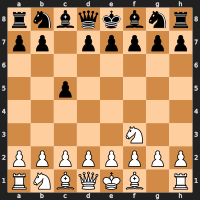

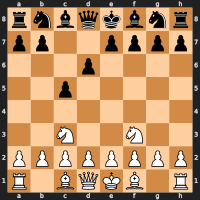

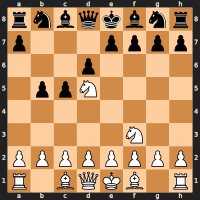

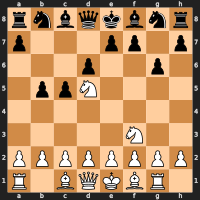

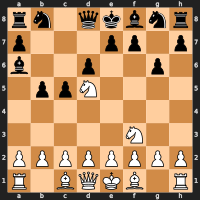

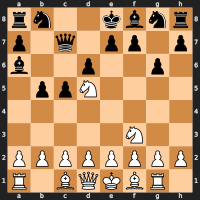

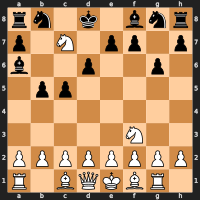

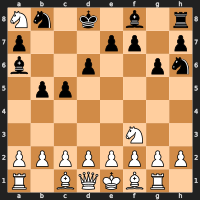

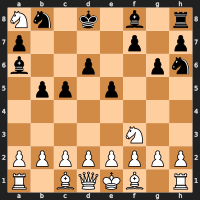

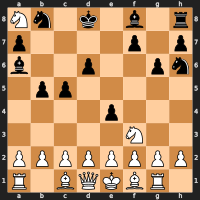

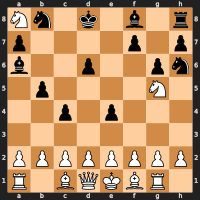

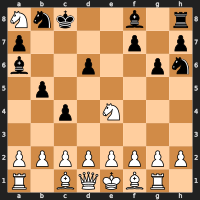

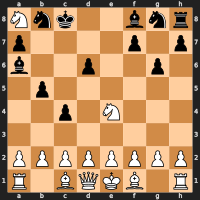

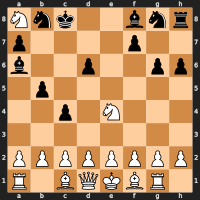

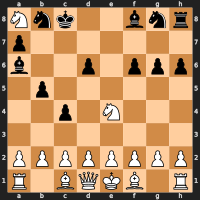

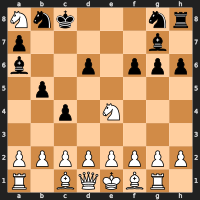

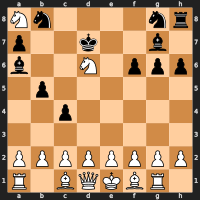

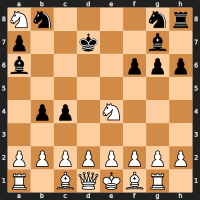

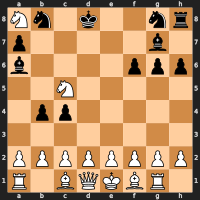

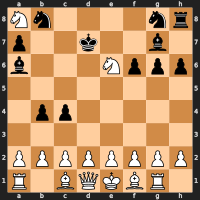

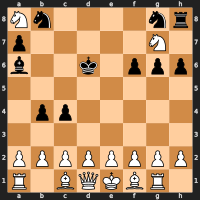

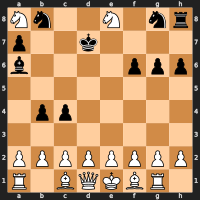

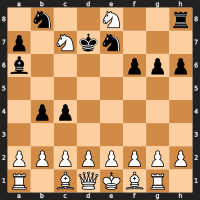

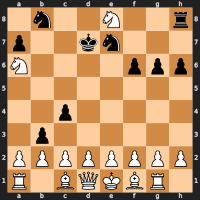

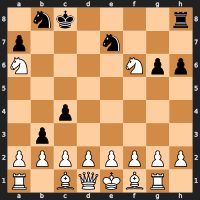

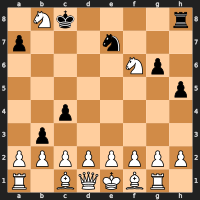

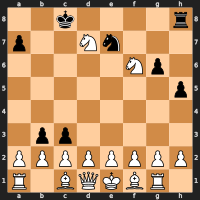

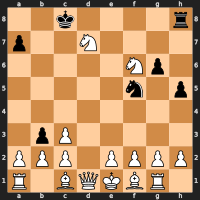

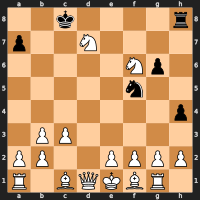

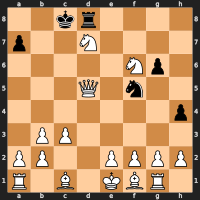

Checkmate! White Wins!
total moves per player:  30


In [11]:
board.reset()
print("Welcome to Chess AI! Here you can play with a friend, AI or battle two AI's and have fun :))))))")
player1_type = input("Do you want to play as the White player or let the AI play (type 'human' or 'ai') ?")
if player1_type == "ai":
    difficulty_1 = input("Exciting! How tough do you want the AI to be?(easy, medium, challenging, pro)")
player2_type = input("Do you want to play as the Black player or let the AI play (type 'human' or 'ai') ?")
if player2_type == "ai":
    difficulty_2 = input("Exciting! How tough do you want the AI to be?(easy, medium, challenging, pro)")

play_game(board, player1_type, player2_type, difficulty_1, difficulty_2)

## Thank you for playing Chess AI